# Text CNN
상품명 정보 등을 활용한 입력값으로 하는 Text CNN 모델.
TextCNN 뒤에 dense layer가 여러개 추가되는 형태.

1) Input  
: 시간 정보, 마더 코드, 상품군, 상품명.
상품명 하나를 집어넣기보다는 시간 정보 등을 넣어줌. 
word embedding의 값은 표준정규분포를 따르도록 초기화됨.

2) Convolutions and MaxPooling  
: Convolution 연산을 통해서 텍스트의 특징과 패턴을 추출함. 이후 MaxPooling을 통해서 가장 뚜렷한 특징을 추출.

3) FC Layer  
: FC layer 4개를 통과하여 추출해낸 특징의 분포를 다양하게 탐색하며, 취급액의 분포를 근사.

## Contents

- Data 준비  
- Dataset 구축    
- Model 정의  
- Model Training  
- Model Evaluation  
- Predict Results

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pickle
import os
import re
%matplotlib inline

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau  # Learning Rate Decay

In [3]:
from torchtext import data as td
from torchtext import datasets

In [4]:
import time
from datetime import date

today = date.today()
print(today)

2020-09-28


In [5]:
torch.manual_seed(0) # random seed 

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
data_path = "../data/" # 데이터 경로
output_path = "../data" # prediction 저장 경로
model_path = "../data" # 모델 저장 경로

## Import Data

In [8]:
df = pd.read_csv(os.path.join(data_path, "df_0927_yujin.csv"))

In [9]:
print(f"DataFrame Shape: {df.shape}")

DataFrame Shape: (38095, 54)


## Data 준비
: 월, 요일, 시간, 마더코드, 상품군, 소분류, 상품명을 하나의 string으로 묶어서 input으로 준비  

In [10]:
df["마더코드"] = df["마더코드"].astype(str)

In [11]:
tmp = df["방송일시"].str.replace("-","").apply(lambda x: x[4:-3]).str.replace(":", " ").apply(lambda x: x[:2] + "월" + x[4:7] + "시" + x[7:] + "분")
text_time = tmp + " " + df["요일"] + " " + df["마더코드"] + " " + df["상품군"] + " " + df["소분류"] + " " + df["상품명"]
text_time = text_time.str.strip()

text_time

0              01월 06시 00분 화요일 100346 의류 니트 테이트 남성 셀린니트 3종
1              01월 06시 00분 화요일 100346 의류 니트 테이트 여성 셀린니트 3종
2              01월 06시 20분 화요일 100346 의류 니트 테이트 남성 셀린니트 3종
3              01월 06시 20분 화요일 100346 의류 니트 테이트 여성 셀린니트 3종
4              01월 06시 40분 화요일 100346 의류 니트 테이트 남성 셀린니트 3종
                               ...                        
38090    07월 00시 10분 수요일 100099 속옷 드로즈 일시불 라쉬반 fc바르셀로나 ...
38091    07월 00시 10분 수요일 100099 속옷 드로즈 무이자 라쉬반 fc바르셀로나 ...
38092     07월 00시 10분 수요일 100099 속옷 드로즈 라쉬반 fc바르셀로나 드로즈 8종
38093       07월 01시 20분 수요일 100261 의류 티셔츠 아놀드파마 티셔츠 레깅스 세트
38094       07월 01시 40분 수요일 100261 의류 티셔츠 아놀드파마 티셔츠 레깅스 세트
Length: 38095, dtype: object

### token length 확인

(array([2.9670e+03, 9.3360e+03, 1.0529e+04, 7.5190e+03, 5.3120e+03,
        1.8240e+03, 4.4400e+02, 1.0700e+02, 6.0000e+00, 5.1000e+01]),
 array([ 9. , 10.1, 11.2, 12.3, 13.4, 14.5, 15.6, 16.7, 17.8, 18.9, 20. ]),
 <a list of 10 Patch objects>)

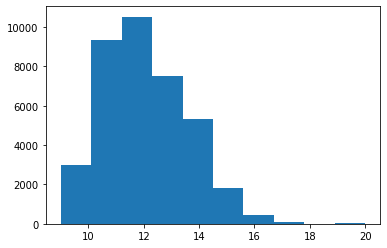

In [12]:
tokens = text_time.str.split(" ")
token_length = tokens.apply(lambda x: len(x))
plt.hist(token_length)

## Train Validation Split

In [13]:
df_tmp = pd.concat([text_time, df[["상품군","취급액"]]], axis = 1)
df_tmp.columns = ["상품정보", "상품군", "취급액"]

In [14]:
train_data = df_tmp[df_tmp["취급액"] != -1]
test_data = df_tmp[df_tmp["취급액"] == -1]

In [15]:
from sklearn.model_selection import train_test_split

grp_dct = {v:k for k, v in enumerate(train_data["상품군"].unique())}
grp_idx = train_data["상품군"].map(grp_dct)
X_train, X_val, y_train, y_val = train_test_split(train_data["상품정보"],train_data['취급액'].astype(float), random_state = 0, stratify = grp_idx)

In [16]:
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_val.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_val.shape}")

X_train shape: (26534,)
X_test shape: (8845,)
y_train shape: (26534,)
y_test shape: (8845,)


In [17]:
pd.DataFrame([X_train, y_train]).T.to_csv(os.path.join(data_path, "text_train.csv"), index = False)
pd.DataFrame([X_val, y_val]).T.to_csv(os.path.join(data_path, "text_valid.csv"), index = False)
train_data[["상품정보", "취급액"]].to_csv(os.path.join(data_path, "text_whole_train.csv"), index = False)
test_data[["상품정보", "취급액"]].to_csv(os.path.join(data_path, "text_test.csv"), index = False)

## Model

In [18]:
# Model Parameter

BATCH_SIZE = 16
LR = 0.003
N_EPOCHS = 100
WEIGHT_DECAY = 1e-5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"Model Batch Size: {BATCH_SIZE}")
print(f"Model Learning Rate: {LR}")
print(f"Model Number Of Epochs: {N_EPOCHS}")
print(f"Model Weight Decay Rate: {WEIGHT_DECAY}")
print(f"Model Device: {device}")

Model Batch Size: 16
Model Learning Rate: 0.003
Model Number Of Epochs: 100
Model Weight Decay Rate: 1e-05
Model Device: cuda


### Dataset 구축

In [19]:
# field 정의

PRODUCT = td.Field(sequential = True, 
                   use_vocab = True, 
                   batch_first = True)

SALES = td.Field(sequential = False,
                 use_vocab = False,
                 preprocessing = lambda x: float(x),
                 dtype = torch.float,
                 batch_first = True)

fields = [('text', PRODUCT), ('target', SALES)]

In [20]:
# data 불러오기

train_data,val_data = td.TabularDataset.splits(
                        path = data_path,
                        train = "text_train.csv",
                        validation = "text_valid.csv",                       
                        format = "csv",
                        fields = fields,
                        skip_header = True
                      )

In [21]:
PRODUCT.build_vocab(train_data)
print(f"Vocabulary Size: {len(PRODUCT.vocab)}")

Vocabulary Size: 2976


In [22]:
# Batch iterator

train_iterator, valid_iterator = td.BucketIterator.splits(
(train_data, val_data),
    sort = False,
    batch_size = BATCH_SIZE,
    device = device
)

### 모델 아키텍처 정의


In [23]:
# code reference: https://github.com/kh-kim/simple-ntc/blob/master/simple_ntc/cnn.py

class TextCNN(nn.Module):
    """
    - Input
    1) input_size: Vocabulary Size (int)
    2) word_vec_dim: Embedding Dimension (int)
    3) dropout_p: Dropout Rate (float)
    4) window_sizes: A list of window sizes (list)
    5) n_filters: A list of which the number of filters for each window size (list)
    6) hidden_sizes: hidden layer sizes (list)

    window size means that how many words a single pattern covers,
    and n_filter means that how many patterns to cover.

    """
    
    def __init__(self, 
                 input_size,
                 word_vec_dim,
                 dropout_p = .5,
                 window_sizes = [3,4,5],
                 n_filters = [100,100,100],
                 hidden_sizes = [1]
                ):
        self.input_size = input_size
        self.word_vec_dim = word_vec_dim
        self.dropout_p = dropout_p
        self.window_sizes = window_sizes
        self.n_filters = n_filters
        self.hidden_sizes = hidden_sizes
        
        super().__init__()
        
        self.emb = nn.Embedding(input_size, word_vec_dim)
        
        # convolution layer 개수는 window_sizes 개수에 따라 달라지므로, layer를 더하기 위해 setattr, getattr 메소드를 사용할 것
        # 이 layer가 sequential하게 이어지는 게 아니라 각각 독립적인 convolution block.
        # layer 개수는 window_sizes*n_filters의 가중합.
        # setattr: 속성 할당 ex) setattr(obj, attr_name, attr_value)
        # getattr: 속성 반환 ex) getattr(obj, attr_name, value to be returned when attr doesnt exist(option))
        
        for window_size, n_filter in zip(window_sizes, n_filters): # convolution layers
            cnn = nn.Conv2d(in_channels = 1, 
                           out_channels = n_filter, 
                           kernel_size = (window_size, word_vec_dim)
                           )
            
            setattr(self, "cnn-%d-%d" % (window_size, n_filter), cnn)

        for idx in range(len(hidden_sizes)): # hidden layers
            if idx == 0:
              dim0 = sum(n_filters)
            else:
              dim0 = hidden_sizes[idx-1]
            
            affine = nn.Linear(dim0, hidden_sizes[idx])
            
            setattr(self, "linear-%d-%d" % (dim0, hidden_sizes[idx]), affine)

            
        self.relu = nn.ReLU() # activation layer
        self.dropout = nn.Dropout(dropout_p) # dropout
        self.generator = nn.Linear(hidden_sizes[idx], 1) # output layer
        
    def forward(self, x):
        """
        Input -> (embedding) -> Convolution (window_sizes * n_filters) -> ReLU -> Dropout -> max_pooling1D -> Dense -> Output

        - Tracking the changing size
        1) input: |x| = (batch_size, length)
        2) After Embedding: |x| = (batch_size, length, word_vec_dim)
        3) After Convolution: |cnn_out| = (batch_size, n_filter, length - window_size + 1, 1)
        4) After MaxPooling: |cnn_out| = (batch_size, n_filters)
        5) After Concat: |cnn_outs| = (batch_size, sum(n_filters))

        """

        # Embedding Layers
        x = self.emb(x)
        min_length = max(self.window_sizes)
        
        ## Window sizes보다 Sequence Length의 길이가 작을 때를 대비하여 zero padding
        if min_length > x.size(1): 
            pad = x.new(x.size(0), min_length - x.size(1), self.word_vec_dim).zero_()
            x = torch.cat([x, pad], dim = 1) 
      
        x = x.unsqueeze(1)
        
        # Conv Layers
        cnn_outs = []
        for window_size, n_filter in zip(self.window_sizes, self.n_filters):
            cnn = getattr(self, "cnn-%d-%d" % (window_size, n_filter))
            cnn_out = self.dropout(self.relu(cnn(x)))
          
            # MaxPooling Layers          
            cnn_out = nn.functional.max_pool1d(input = cnn_out.squeeze(-1),
                                              kernel_size = cnn_out.size(-2)
                                              ).squeeze(-1)
            
            cnn_outs += [cnn_out] # len(cnn_out) for each: number of feature map
        
        cnn_outs = torch.cat(cnn_outs, dim = -1) # hstack
        
        # Dense Layers
        affine_in = cnn_outs
        for idx in range(len(self.hidden_sizes)):
          if idx == 0:
            dim0 = sum(self.n_filters)
          else:
            dim0 = self.hidden_sizes[idx-1]
          affine = getattr(self, "linear-%d-%d" % (dim0, self.hidden_sizes[idx]))
          affine_out = self.dropout(self.relu(affine(affine_in)))
          affine_in = affine_out

        # Output
        y = self.generator(affine_out)
        
        return y

### Model Train
: MAPE 정의, train & evaluate 함수 정의

In [24]:
def mape(y_pred, y_true):
    """
    Loss Function & Eval metric at the same time.
    Returns mape
    """
    return torch.mean(torch.abs((y_true-y_pred)/y_true)) * 100

In [25]:
def train(model, iterator, optimizer, batch_size=BATCH_SIZE):
    """
    model training
    """
    
    epoch_loss = 0
    epoch_mape = 0
    
    model.train() # train
    
    for batch in iterator:
                
        optimizer.zero_grad()
        
        predictions = model(batch.text).squeeze(1)

        loss_ = mape(predictions, batch.target)
        mape_ = mape(predictions, batch.target)
        
        loss_.backward() # backpropagation
        optimizer.step() # updating parameters
        
        epoch_loss += loss_.item()
        epoch_mape += mape_.item()
        
    return epoch_loss / len(iterator), epoch_mape / len(iterator)      
        

In [26]:
def evaluate(model, iterator):
    """
    evaluating model
    """
    
    epoch_loss = 0
    epoch_mape = 0
    
    model.eval()
    
    with torch.no_grad():
        
        for batch in iterator:
            
            predictions = model(batch.text).squeeze(1)
            
            loss_ = mape(predictions, batch.target)
            mape_ = mape(predictions, batch.target)
    
            
            epoch_loss += loss_.item()
            epoch_mape += mape_.item()
            
    return epoch_loss / len(iterator), epoch_mape / len(iterator)

In [27]:
def epoch_time(start_time, end_time):
    """
    check epoch time
    """
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [28]:
# 모델 선언
"""
ReduceLROnPlateau: loss가 더이상 감소하지 않으면 learning rate를 조정함.
factor: learning rate decay rate
patience: after steps of patience, learning rate decaying started
"""
model = TextCNN(len(PRODUCT.vocab), 
                32,
                0.1,
                window_sizes = [1,2,3,4,5,6,7,8,9],
                n_filters = [15,15,30,35,35,30,15,15,15],
                hidden_sizes = [64,16,4])


optimizer = optim.Adam(model.parameters(), lr = LR, weight_decay = WEIGHT_DECAY)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.8, patience=10, verbose=True)
model = model.to(device)

In [29]:
# Train

best_valid_loss = float('inf')
save_checkpoint = False # whether to save checkpoint
train_loss_list = []
valid_loss_list = []

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss, train_mape = train(model, train_iterator, optimizer)
    valid_loss, valid_mape = evaluate(model, valid_iterator)

    scheduler.step(valid_loss)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    train_loss_list.append(train_loss)
    valid_loss_list.append(valid_loss)
    
    if valid_loss < best_valid_loss:
      best_valid_loss = valid_loss
      
      ## save the checkpoint
      if save_checkpoint:
        torch.save({
              'epoch': epoch,
              'model_state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              'loss': valid_loss
              }, f"{model_path}{today}-model_checkpoint.tar")
      else: ## save the model only
        torch.save(model.state_dict(), f"{model_path}{today}-model.pt")
      
        
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train MAPE: {train_mape:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. MAPE: {valid_mape:.2f}%')

Epoch: 01 | Epoch Time: 0m 15s
	Train Loss: 92.197 | Train MAPE: 92.20%
	 Val. Loss: 60.593 |  Val. MAPE: 60.59%
Epoch: 02 | Epoch Time: 0m 14s
	Train Loss: 54.436 | Train MAPE: 54.44%
	 Val. Loss: 49.716 |  Val. MAPE: 49.72%
Epoch: 03 | Epoch Time: 0m 14s
	Train Loss: 48.678 | Train MAPE: 48.68%
	 Val. Loss: 46.708 |  Val. MAPE: 46.71%
Epoch: 04 | Epoch Time: 0m 14s
	Train Loss: 46.212 | Train MAPE: 46.21%
	 Val. Loss: 45.514 |  Val. MAPE: 45.51%
Epoch: 05 | Epoch Time: 0m 14s
	Train Loss: 44.613 | Train MAPE: 44.61%
	 Val. Loss: 44.608 |  Val. MAPE: 44.61%
Epoch: 06 | Epoch Time: 0m 15s
	Train Loss: 43.419 | Train MAPE: 43.42%
	 Val. Loss: 43.155 |  Val. MAPE: 43.15%
Epoch: 07 | Epoch Time: 0m 14s
	Train Loss: 42.468 | Train MAPE: 42.47%
	 Val. Loss: 41.893 |  Val. MAPE: 41.89%
Epoch: 08 | Epoch Time: 0m 14s
	Train Loss: 41.139 | Train MAPE: 41.14%
	 Val. Loss: 42.027 |  Val. MAPE: 42.03%
Epoch: 09 | Epoch Time: 0m 14s
	Train Loss: 39.882 | Train MAPE: 39.88%
	 Val. Loss: 39.596 |  V

In [30]:
print(f"best valid loss for {best_valid_loss} epochs : {N_EPOCHS}")

best valid loss for 31.485136621899457 epochs : 100


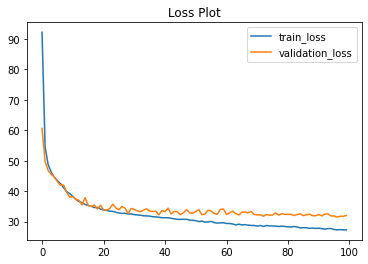

In [31]:
plt.title("Loss Plot")
plt.plot(train_loss_list)
plt.plot(valid_loss_list)
plt.legend(["train_loss", "validation_loss"])

### 전체 Train set으로 재학습

In [32]:
final_train_data = td.TabularDataset.splits(
                        path = data_path,
                        train = "text_whole_train.csv",
                        #test = "text_test.csv",
                        format = "csv",
                        fields = fields,
                        skip_header = True
                      )[0] # tuple unpacking

PRODUCT.build_vocab(final_train_data)
whole_train_iterator = td.BucketIterator(final_train_data, batch_size = BATCH_SIZE, device = device)

In [33]:
len(PRODUCT.vocab)

2986

In [38]:
# 전체 트레인셋에 대해 학습 후 최종 예측 진행

def final_train(train_iterator, n_epochs):
  model = TextCNN(len(PRODUCT.vocab), 
                32,
                0.1,
                window_sizes = [1,2,3,4,5,6,7,8,9],
                n_filters = [15,15,30,35,35,30,15,15,15],
                hidden_sizes = [64,16,4])


  optimizer = optim.Adam(model.parameters(), lr = LR, weight_decay = WEIGHT_DECAY)
  model = model.to(device)

  for epoch in range(n_epochs):
    
    start_time = time.time()
    
    train_loss, train_mape = train(model, train_iterator, optimizer)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train MAPE: {train_mape:.2f}%')

  return model

In [39]:
models_list = [final_train(whole_train_iterator, epochs) for epochs in [20,30,40]] # 20,30,40 training epochs

Epoch: 01 | Epoch Time: 0m 18s
	Train Loss: 78.594 | Train MAPE: 78.59%
Epoch: 02 | Epoch Time: 0m 18s
	Train Loss: 51.260 | Train MAPE: 51.26%
Epoch: 03 | Epoch Time: 0m 18s
	Train Loss: 46.976 | Train MAPE: 46.98%
Epoch: 04 | Epoch Time: 0m 18s
	Train Loss: 44.093 | Train MAPE: 44.09%
Epoch: 05 | Epoch Time: 0m 18s
	Train Loss: 42.291 | Train MAPE: 42.29%
Epoch: 06 | Epoch Time: 0m 18s
	Train Loss: 40.912 | Train MAPE: 40.91%
Epoch: 07 | Epoch Time: 0m 18s
	Train Loss: 40.132 | Train MAPE: 40.13%
Epoch: 08 | Epoch Time: 0m 18s
	Train Loss: 39.359 | Train MAPE: 39.36%
Epoch: 09 | Epoch Time: 0m 18s
	Train Loss: 38.564 | Train MAPE: 38.56%
Epoch: 10 | Epoch Time: 0m 18s
	Train Loss: 37.633 | Train MAPE: 37.63%
Epoch: 11 | Epoch Time: 0m 18s
	Train Loss: 37.000 | Train MAPE: 37.00%
Epoch: 12 | Epoch Time: 0m 18s
	Train Loss: 36.112 | Train MAPE: 36.11%
Epoch: 13 | Epoch Time: 0m 18s
	Train Loss: 35.579 | Train MAPE: 35.58%
Epoch: 14 | Epoch Time: 0m 18s
	Train Loss: 35.000 | Train MAPE:

## Make A Prediction

In [40]:
test_final = pd.read_csv(os.path.join(data_path, "text_test.csv"))

In [69]:
def get_idx_tokens(data):
  """
  Getting index from text data
  """

  tokens = data.iloc[:,0].str.split(" ")
  max_len =tokens.apply(len).max()
  word_to_idx = dict(PRODUCT.vocab.stoi)
  
  def get_matching_idx(lst):
    res = []
    for i in lst:
      if i in word_to_idx.keys():
        res.append(word_to_idx[i])
      else:
        res.append(0)
    return res
  token_idx = tokens.apply(lambda x: get_matching_idx(x))
  token_idx_padded = token_idx.apply(lambda x: x + [1] * (max_len - len(x)))

  return torch.LongTensor(token_idx_padded).to(device)

def get_predict(seq, model):
  """
  make predictions
  """
  model.eval()
  with torch.no_grad():

    predictions = model(seq).squeeze(1)

  return predictions.cpu().numpy()

In [42]:
# get_predict
val_padded = get_idx_tokens(test_final)

In [49]:
unk_mask = pd.Series(val_padded.cpu()).apply(lambda x: x.count(0) / len(x) >= 0.3 ) # unknown token 비율이 0.3이상인 데이터를 걸러냄
unk_mask_idx = np.where(unk_mask == True)

In [73]:
res = np.array([get_predict(val_padded, mdl) for mdl in models_list])

In [78]:
res_avg = res.mean(axis = 0)

In [82]:
# Writing results

test_final["취급액"] = res_avg
test_final["취급액"].to_csv(os.path.join(output_path, "text_cnn_final_predictions.csv"), index = False)

with open(os.path.join(output_path, "unk_token_masking.pickle"), "wb") as f:
  pickle.dump(unk_mask_idx, f)